# RNN 이해 및 실습

## 1. 시계열 데이터

- 예제 시계열 만들기

In [1]:
import numpy as np
import matplotlib.pyplot as plt

xarr = np.array([100,200,300,400])
yarr = np.array([1,2,3,4])
cond = ([True,False,True,False])
np.where(cond,xarr,yarr) #cond True->xarr, False ->yarr

array([100,   2, 300,   4])

In [2]:
np.random.seed(2020)
time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5,
                          np.cos(2 * np.pi * month_time),
                          np.cos(2 * np.pi * month_time) + np.random.random(361))


In [3]:
time_series

array([ 2.00000000e+01,  1.95629520e+01,  1.82709092e+01,  1.61803399e+01,
        1.33826121e+01,  1.00000000e+01,  6.18033989e+00,  2.09056927e+00,
       -2.09056927e+00, -6.18033989e+00, -1.00000000e+01, -1.33826121e+01,
       -1.61803399e+01, -1.82709092e+01, -1.95629520e+01, -6.66393899e+00,
       -1.52209392e+01, -7.04236950e+00, -1.36967643e+01, -6.98788244e+00,
        9.06427746e+00, -3.43320407e+00,  9.29769267e+00,  2.16038789e+01,
        1.62476811e+01,  2.33532841e+01,  1.40664421e+01,  2.53027272e+01,
        2.13879364e+01,  2.90839313e+01,  2.00000000e+01,  1.95629520e+01,
        1.82709092e+01,  1.61803399e+01,  1.33826121e+01,  1.00000000e+01,
        6.18033989e+00,  2.09056927e+00, -2.09056927e+00, -6.18033989e+00,
       -1.00000000e+01, -1.33826121e+01, -1.61803399e+01, -1.82709092e+01,
       -1.95629520e+01, -1.68766917e+01, -6.82506738e+00, -7.15699540e+00,
       -1.23417656e+01, -4.86949247e+00,  2.68404157e-01, -7.92788173e-01,
        9.88983111e+00,  

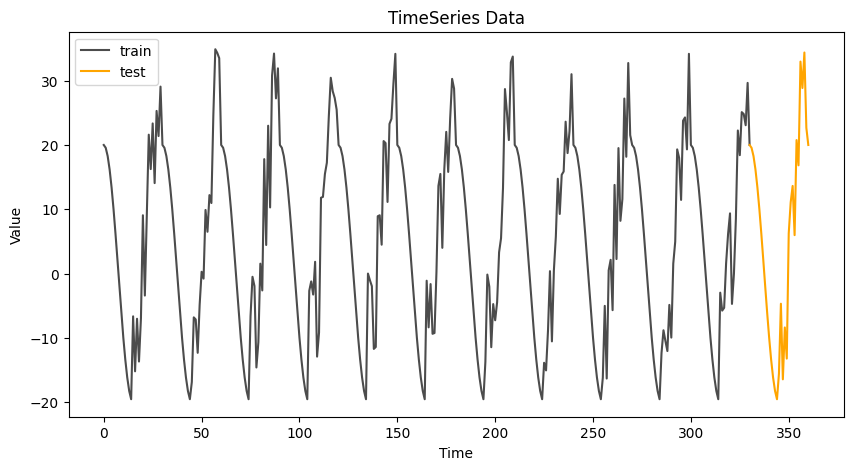

In [4]:
plt.figure(figsize = (10, 5))
plt.title('TimeSeries Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(np.arange(0, 30 * 11 + 1), time_series[:30 * 11 + 1], color = 'black', alpha = 0.7, label = 'train') # 학습용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1), time_series[30 * 11:], color = 'orange', label = 'test') # 테스트용 데이터
plt.legend()

## 2. 시계열 데이터 전처리 : Sequence를 만들기

In [5]:
def make_sequence(time_series, n):  #시계열에서 1부터 n번째까지 선택해서 x로 지정, n+1번째값은 y, 이런 식으로 시계열 값을 계속 윈도우 n크기로 슬라이딩
    x_train, y_train = list(), list()

    for i in range(len(time_series)):
        x = time_series[i:(i + n)]
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break

    return np.array(x_train), np.array(y_train)

n = 15
x_train, y_train = make_sequence(time_series, n)
x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)
print(x_train.shape)
print(y_train.shape)

(346, 15, 1)
(346, 1)


In [6]:
from sklearn.model_selection import train_test_split

partial_x_train = x_train[:30 * 11]
partial_y_train = y_train[:30 * 11]
x_test = x_train[30 * 11:]
y_test = y_train[30 * 11:]

print('train:', partial_x_train.shape, partial_y_train.shape)
print('test:',x_test.shape, y_test.shape)

train: (330, 15, 1) (330, 1)
test: (16, 15, 1) (16, 1)


## 3. sequence 함수 확인하기

In [7]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 15)

for i in range(1, 4):
    print(a[i],'|', b[i])


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] | 16
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] | 17
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] | 18


## 4. SimpleRNN 구축

- tanh: Hyperbolic tangent 함수
- -1~1사이의 값, 출력범위가 sigmoid보다 크고, 경사가 큰 구간이 많아 sigmoid보다 빠르게 수렴하여 학습하는 특성
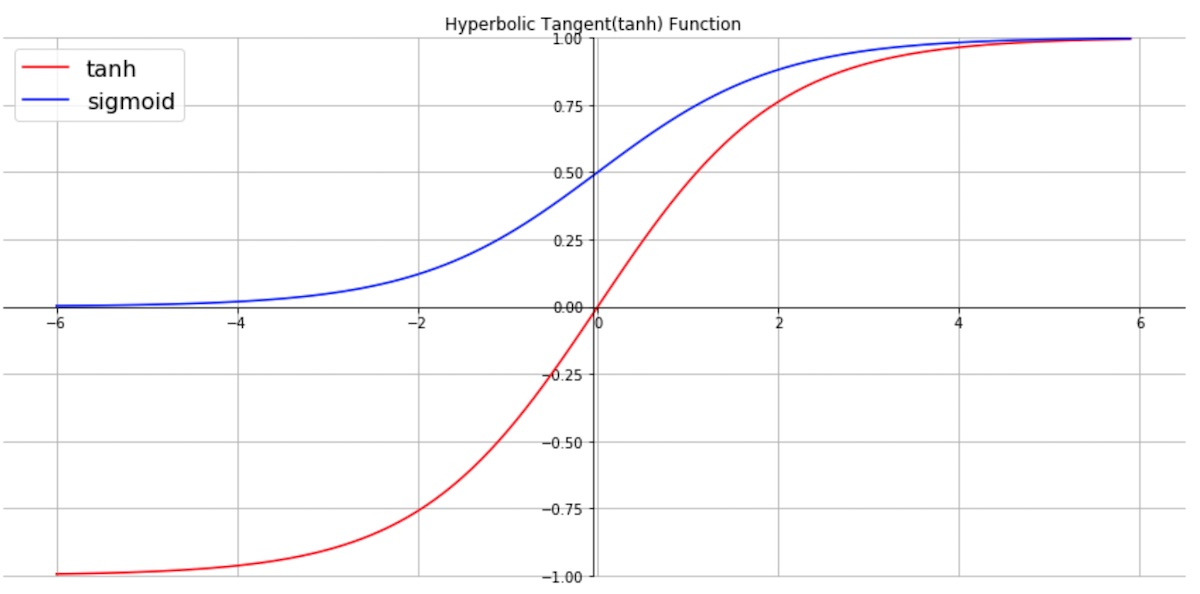

In [8]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN 층을 첫 번째 은닉층인 경우, input_shape를 명시
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
#model.add(LSTM(units = 32, activation = 'tanh', input_shape = (n, 1)))
#model.add(GRU(units = 32, activation = 'tanh', input_shape = (n, 1)))

#rnn은 이전 단계의 가중치를 사용하며, relu 를 사용하면, 역전파 시 이전 단계의 그라디언트와 같이 사용되면 출력이 발산
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(x_train, y_train, epochs = 30, batch_size = 1)

Epoch 1/30
346/346 [==============================] - 5s 10ms/step - loss: 124.1577
Epoch 2/30
346/346 [==============================] - 2s 6ms/step - loss: 76.1805
Epoch 3/30
346/346 [==============================] - 3s 8ms/step - loss: 62.0214
Epoch 4/30
346/346 [==============================] - 3s 8ms/step - loss: 55.1264
Epoch 5/30
346/346 [==============================] - 3s 7ms/step - loss: 49.5294
Epoch 6/30
346/346 [==============================] - 4s 11ms/step - loss: 45.0618
Epoch 7/30
346/346 [==============================] - 2s 6ms/step - loss: 40.2496
Epoch 8/30
346/346 [==============================] - 3s 8ms/step - loss: 36.4441
Epoch 9/30
346/346 [==============================] - 3s 7ms/step - loss: 33.3567
Epoch 10/30
346/346 [==============================] - 2s 6ms/step - loss: 31.7076
Epoch 11/30
346/346 [==============================] - 3s 9ms/step - loss: 30.1954
Epoch 12/30
346/346 [==============================] - 3s 8ms/step - loss: 29.2419
Epoch 13/3

- pykrx에서 삼성전자 주가를 2022.1~6 받아보세요.
- 종가를 사용해서, time step을 5로 지정하셔서 SimpleRNN을 적용해보세요

In [10]:
!pip install pykrx

from pykrx import stock
stock.get_market_ohlcv_by_date(fromdate="20220101", todate="20220630", ticker="005930")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 28.6 MB/s eta 0:00:00


시가     고가     저가     종가       거래량       등락률
날짜                                                        
2022-01-03  79400  79800  78200  78600  13502112  0.383142
2022-01-04  78800  79200  78300  78700  12427416  0.127226
2022-01-05  78800  79000  76400  77400  25470640 -1.651842
2022-01-06  76700  77600  76600  76900  12931954 -0.645995
2022-01-07  78100  78400  77400  78300  15163757  1.820546
...           ...    ...    ...    ...       ...       ...
2022-06-24  57900  59100  57700  58400  23256103  1.742160
2022-06-27  59000  59900  58300  58800  18122236  0.684932
2022-06-28  59200  59500  58700  59400  13540538  1.020408
2022-06-29  58500  58800  58000  58000  14677138 -2.356902
2022-06-30  57200  57600  57000  57000  18915142 -1.724138

[121 rows x 6 columns]

- 구글트렌드에서 검색어를 사용하셔서 검색량 통계를 다운로드 받으세요
- csv를 읽으셔서, 검색량에 대한 시퀀스(x,y)를 만들어주세요
- SimpleRNN으로 피팅해보세요.


In [ ]:
import pandas as pd
trend = pd.read_csv("trend.csv")
data = trend.search.values / 100

#1 time step 3
n=3
x_train, y_train = make_sequence( data, n )
#2 RNN
model = Sequential()
model.add(SimpleRNN(units = 8, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
model.add(Dense(1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.fit(x_train, y_train, epochs=10)

In [ ]:
np.sqrt( 0.0405 )*100

20.12461179749811

In [ ]:
#!pip install pykrx
from pykrx import stock
price = stock.get_market_ohlcv_by_date(fromdate="20220101", todate="20220630", ticker="005930")
price2 = price["종가"].values
x_train, y_train = make_sequence(price2, 5)
x_train = x_train.reshape(-1, 5, 1)
y_train = y_train.reshape(-1, 1)
partial_x_train = x_train[:100]
partial_y_train = y_train[:100]
x_test = x_train[100:]
y_test = y_train[100:]

In [ ]:
n=5
model = Sequential()
#model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1))) #units: output의 dimension, relu대신 tanh 사용
#model.add(LSTM(units = 32, activation = 'tanh', input_shape = (n, 1)))
model.add(GRU(units = 32, activation = 'tanh', input_shape = (n, 1)))
model.add(Dense(1, activation = 'linear'))
model.compile(optimizer = 'adam', loss = 'mse')  #mean squared error
model.fit(partial_x_train, partial_y_train, epochs=20)
model.evaluate( x_test, y_test)


Epoch 1/20
4/4 [==============================] - 2s 6ms/step - loss: 4954971136.0000
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 4954964480.0000
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - loss: 4954956800.0000
Epoch 4/20
4/4 [==============================] - 0s 5ms/step - loss: 4954949120.0000
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 4954941952.0000
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - loss: 4954934784.0000
Epoch 7/20
4/4 [==============================] - 0s 6ms/step - loss: 4954927616.0000
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 4954920448.0000
Epoch 9/20
4/4 [==============================] - 0s 7ms/step - loss: 4954912768.0000
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 4954905088.0000
Epoch 11/20
4/4 [==============================] - 0s 6ms/step - loss: 4954897920.0000
Epoch 12/20
4/4 [==============================] - 0

3591786240.0

## 5. 예측 VS Actual


In [11]:
print( np.sqrt( np.mean((model.predict(x_test ).reshape(16,) - y_test.reshape(16,))**2 )))


1/1 [==============================] - 1s 989ms/step
5.969390511473241


1/1 [==============================] - 0s 94ms/step


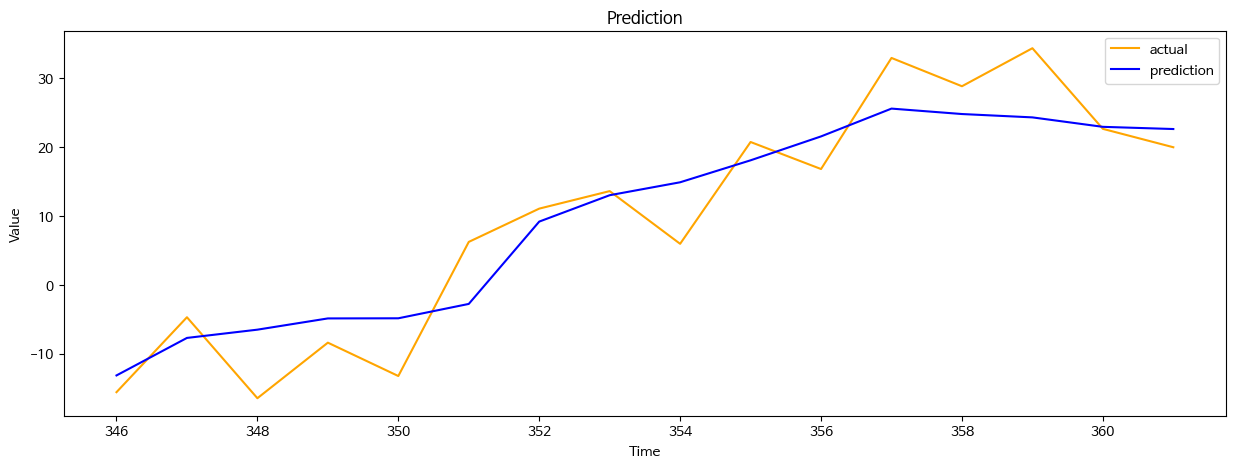

In [12]:
pred = model.predict(x_test)
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

## 6. 두번째 RNN 실습




- RNN 입력 x 데이터의 shape: (n_sample, time step, x vector의 크기)
 - n_sample: sample의 수
 - time step: t-n 에서 n이 몇인가를 묻는 것
 - x vector의 크기: 현재는 1개, 추후 여러 값이 입력, 여러값이 출력될 수 있음. x변수의 값 1개의 크기임
 - xvector의 크기 = yvector의 크기와 동일

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

s = np.sin(2 * np.pi * 0.125 * np.linspace(0, 20, 50))
timestep =3 # t-3, t-2, t-1 데이터를 이용하여 t 시점의 값을 예측
xs, ys = [], []

for i in range(timestep, len(s)):
    xs.append(np.array([s[i-j] for j in range(timestep, 0, -1)]))
    ys.append(s[i])
xs, ys = np.array(xs).reshape(len(xs), 3, 1), np.array(ys).reshape(len(ys), 1)
print(xs.shape)

(47, 3, 1)


In [14]:
## rnn 적용.
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

## simple RNN model
np.random.seed(0)# seed 고정
model0 = Sequential()
model0.add( SimpleRNN(units=1, input_shape=(3, 1)))
model0.compile(loss='mse', optimizer='sgd')
history0 = model0.fit(xs, ys, epochs=150, verbose=0)

In [15]:
model1 = Sequential()
model1.add( SimpleRNN(units=10, input_shape=(3, 1)) )
model1.add( Dense(10, activation='linear') )
model1.add( Dense(1, activation='linear') )
model1.compile(loss='mse', optimizer='sgd')
history1 = model1.fit(xs, ys, epochs=150, verbose=0)

2/2 [==============================] - 0s 9ms/step


<ipython-input-16-6bf5e40a88af>:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(model0.predict(xs), 'bo-', marker='o', label='model0')


2/2 [==============================] - 0s 5ms/step


<ipython-input-16-6bf5e40a88af>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(model1.predict(xs), 'go-', marker='o', label='model1')


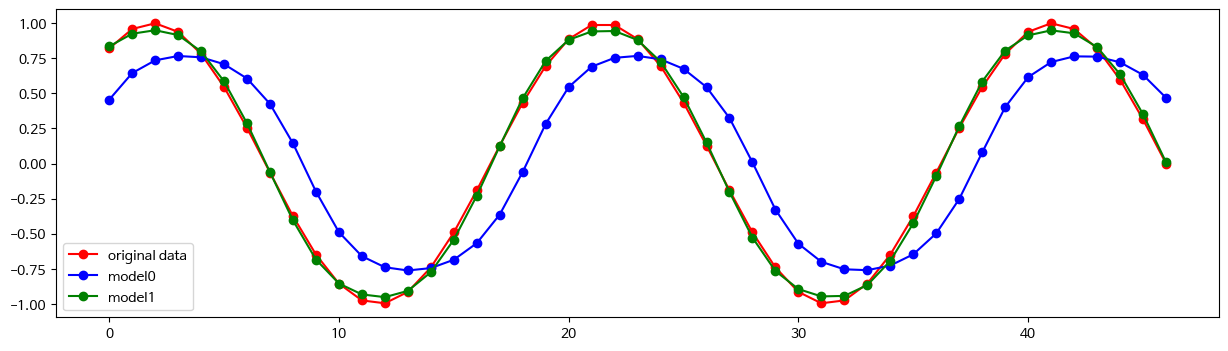

In [16]:
## plot
fig = plt.figure(figsize=(15, 4))
plt.plot(s[3:], 'ro-', label='original data') # 원래 plot, 앞의 3칸의 경우,
plt.plot(model0.predict(xs), 'bo-', marker='o', label='model0')
plt.plot(model1.predict(xs), 'go-', marker='o', label='model1')
plt.legend()

plt.savefig('simple_rnn.svg')
plt.show()

# 7. 주가+RNN

##1. 시계열 분석
-정상 프로세스 VS 비정상 프로세스
 - 정상 프로세스(Stationary Process): 시계열 자료의 평균과 분산이 시간에 관계없이 일정한 겨우
 - 비정상 프로세스(Non-stationary Process): 시계열 자료의 평균과 분산이 일정하지 않은 경우

- 정상 VS 비정상 비교를 위해서 ACF를 확인
 - Autocorrelation Function으로 특정 패턴이 없으면 정상 프로세스로 고려
 - ACF: 자기 상관 함수, k시간 단위로 구분된 시계열의 관측치 사이의 상관계수 함수, k가 커지면 ACF는 0에 가까워짐
 - t시점의 y와 t-k시점의 y의 ACF
 - ACF가 패턴이 없거나 갑자기 떨어지는 모습->정상 시계열
 -
 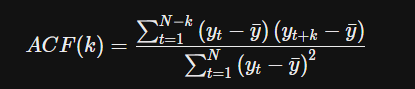
 - PACF(Partial ACF)
  - 부분상관(Partial Corr): 두 확률변수에 의해 다른 변수들에 나타난 상관관계를 설명한 후 남아있는 상관관계
  - PACF는 시계열 관측치 간의 상관관계, k시차에서의 '순수한' 상관관계(두 시점 사이 다른 관측치의 영향력은 제거)
  - t 시점의 y와 t-k 시점의 y의 편자기상관

- AR 모형: 자기 자신을 y로 하고, 시차 p인 이전 시점의 시계열 값들을 x변수로 하는 모형, 시차 p 를 하이퍼파라미터
- MA 모형: 자기 자신이 y이고, 해당 시점과 시차 q인 과거의 white noise error들이 x변수인 모형, 하이퍼파라미터는 시차 q
-  ARMA모형: 자기 자신을 y로 하고, 이전 시점(p)의 시계열과 white noise error들을 x변수로 하는 모형, p,q가 하이퍼파라미터
- ARIMA모형: 위의 세 모형은 정상 프로세스에서의 경우, 비정상 프로세스는 차분을 통해 모형 적용, 차분을 d회 적용한 ARMA모형
 - 차분은 대체로 2회까지, 3회를 넘긴 경우 다른 모형 피팅

- ACF, PACF를 통해서 ARIMA 모형의 p,q를 결정
 - MA(q):
  - ACF: q 시차 이후 0으로 절단
  - PACF: 지수적으로 감소 소멸하는 형태
 - AR(P)
  - ACF: 지수적으로 감소 소멸하는 형태
  - PACF: p 시차 이후 0으로 절단
 - ARMA(p,q)
  - ACF: 시차 (q-p) 이후 부터 소멸
  - PACF: 시차(q-p)이후부터 소멸
  -  p + q < 2, p * q = 0, 대부분은 한 경향을 갖기 때문
- 모형 확인
 - Residuals에 대해서 ACF를 생성
 - 대부분이 영역 안에 들어오고, 40개 중 2-3개 까지는 영역 밖에 있어도 괜찮음


## 1. 시계열 데이터에 대한 RNN 적용

In [27]:
import pandas as pd
data=pd.read_csv('AMZN.csv', header=0,index_col="Date")
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2019-04-17 to 2020-04-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8+ KB


Open         High          Low        Close    Adj Close  \
count   252.000000   252.000000   252.000000   252.000000   252.000000   
mean   1864.800556  1883.242064  1846.651429  1866.393093  1866.393093   
std     110.513502   116.543016   110.148293   114.338644   114.338644   
min    1641.510010  1725.000000  1626.030029  1676.609985  1676.609985   
25%    1778.007507  1793.577515  1762.510040  1783.422516  1783.422516   
50%    1842.005005  1870.639954  1826.875000  1854.284973  1854.284973   
75%    1921.224945  1936.729981  1898.567535  1912.812469  1912.812469   
max    2346.000000  2461.000000  2335.000000  2408.189941  2408.189941   

             Volume  
count  2.520000e+02  
mean   4.060800e+06  
std    2.035731e+06  
min    8.813000e+05  
25%    2.748850e+06  
50%    3.410900e+06  
75%    4.754375e+06  
max    1.556730e+07

In [28]:
print(data.head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-04-17  1872.989990  1876.469971  1860.439941  1864.819946  1864.819946   
2019-04-18  1868.790039  1870.819946  1859.479980  1861.689941  1861.689941   
2019-04-22  1855.400024  1888.420044  1845.640015  1887.310059  1887.310059   
2019-04-23  1891.199951  1929.260010  1889.579956  1923.770020  1923.770020   
2019-04-24  1925.000000  1929.689941  1898.160034  1901.750000  1901.750000   

             Volume  
Date                 
2019-04-17  2893500  
2019-04-18  2749900  
2019-04-22  3373800  
2019-04-23  4640400  
2019-04-24  3675800  


In [29]:
data.shape

(252, 6)

In [31]:
# amazon.com의 close 컬럼을 사용하셔서,
# 1 sequence를 만드세요 (make_sequence, time step=....
x_train, y_train = make_sequence( data.Close.values, 3)
x_train = x_train.reshape( -1, 3, 1)
y_train = y_train.reshape( -1, 1)

# 1.5 처음부터225개까지가 train, 226~252까지 test
x_train2 = x_train[ : 225]
y_train2 = y_train[ : 225]
x_test = x_train[ 225: ]
y_test = y_train[ 225: ]

# 2 SimpleRNN을 적용하세요
model2 = Sequential()
model2.add( SimpleRNN(units=1, input_shape=(3, 1)) )
model2.compile(loss='mse', optimizer='adam')
history2 = model2.fit(x_train2, y_train2, epochs=50, verbose=0)

# 3 test셋으로 evaluate 해보세요.
model2.evaluate( x_test, y_test)


1/1 [==============================] - 0s 401ms/step - loss: 3913506.7500


3913506.75

In [34]:
!pip install -U pykrx

from pykrx import stock

stock1 = stock.get_market_ticker_name("000660")
stock1

df = stock.get_market_ohlcv_by_date("20210104", "20211231", "005930")
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', "Change"]
df
data=df

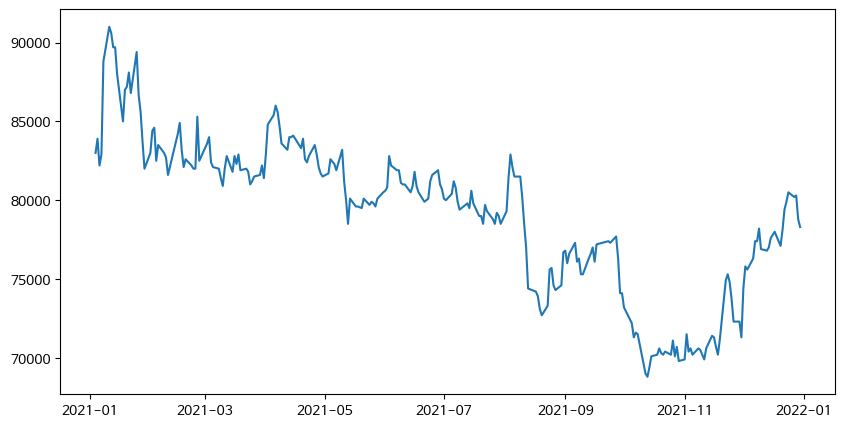

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(data['Close'])
plt.show()

- 정상성(Stationarity)
 - RNN이나 좋은 기법이라 하더라도 시계열 자료가 정상성이 결여된 경우 성능이 좋지 않을 수 있음
 - 정상성이란: 시계열 자료가 뚜렷한 트렌드 없이 값의 변동이 시간의 흐름에 따라 일정, stationarity
 - 정상성 여부의 검정: Dickey Fuller의 단위근 검정
  - 귀무가설: 비정상시계열 (단위근 있다)
  - 대립가설: 정상시계열(단위근 없다)

 - 비정상시계열인 경우: 시계열 자료 차분(differencing)하여 정상시계열로 변환 후 피팅

 - 주가: 일반적으로 비정상 시계열, 로그수익율인 경우 정상시계열이 됨
 - 수익율 = 현재 가격/과거 가격
 - 로그수익율: log현재가격-log과거가격 = log(현재가격/과거가격)


In [36]:
#!pip install statsmodels
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller    #종가의 정상성 여부 점검
result=adfuller(data['Close'])
print(result) #0.5933이 p-value, 비정상 시계열

(-1.8660739163103446, 0.34818538521662656, 0, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 3830.8195835262513)


- acf, pacf
 - acf: 자기상관함수, autocorrelation function, k기간 떨어진 값들의 상관 계수
 - pacf: 편자기상관함수, partial autocorrelation function, 서로 다른 두 지점 사이의 관계를 분석할때, 중간에 있는 값들의 영향을 제외시킨 상관계수

 - p가 증가 시, 지수적 감소 혹은 절단 형태여야 정상성, 둘 중 하나라도 느리게 감소하거나 증가 시 비정상성

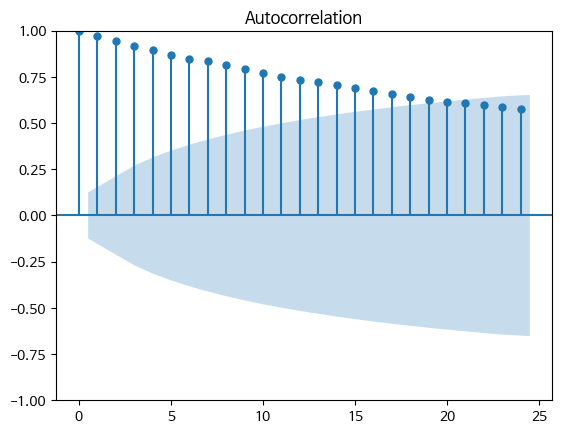

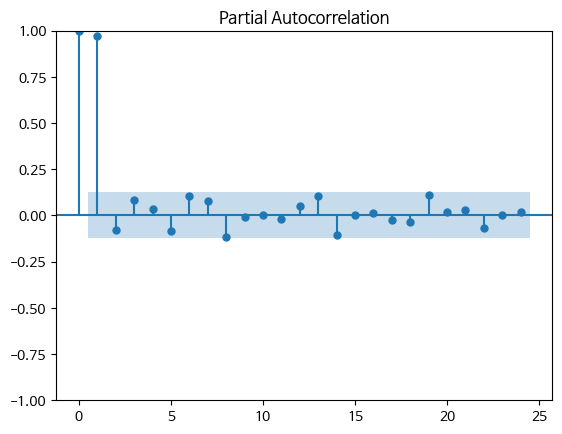

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['Close']) #느리게 감소, 비정상시계열
plot_pacf(data['Close'])
plt.show()

In [38]:
data.diff() #differencing 차이를 구해줌 ->주가가 아닌 경우에 사용

Open    High     Low   Close      Volume    Change
날짜                                                              
2021-01-04     NaN     NaN     NaN     NaN         NaN       NaN
2021-01-05   600.0  -500.0  1400.0   900.0  -3319607.0 -1.384798
2021-01-06  1700.0   600.0   500.0 -1700.0   6753344.0 -3.110559
2021-01-07  -500.0  -300.0   600.0   700.0  -9444371.0  2.877803
2021-01-08   500.0  5800.0   300.0  5900.0  26368665.0  6.265427
...            ...     ...     ...     ...         ...       ...
2021-12-24   400.0   800.0   900.0   600.0  -1491118.0  0.121216
2021-12-27   400.0  -200.0  -400.0  -300.0  -1303012.0 -1.123609
2021-12-28  -400.0  -200.0  -100.0   100.0   7442957.0  0.497359
2021-12-29     0.0  -200.0 -1200.0 -1500.0   1568470.0 -1.992683
2021-12-30 -1300.0  -700.0  -400.0  -500.0  -5558095.0  1.233477

[248 rows x 6 columns]

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


             Open        High         Low       Close      Volume      Change
count  247.000000  247.000000  247.000000  247.000000  247.000000  132.000000
mean    -0.000106   -0.000242   -0.000107   -0.000236   -0.004044         NaN
std      0.015147    0.013912    0.012226    0.013617    0.283487         NaN
min     -0.040052   -0.057402   -0.045330   -0.035591   -0.858579        -inf
25%     -0.007996   -0.007348   -0.006969   -0.007339   -0.185996   -1.102321
50%      0.000000    0.000000   -0.001219   -0.001234    0.002140   -0.090192
75%      0.007371    0.006873    0.005063    0.007221    0.176373    0.692529
max      0.077361    0.072837    0.075398    0.068752    0.833300         inf


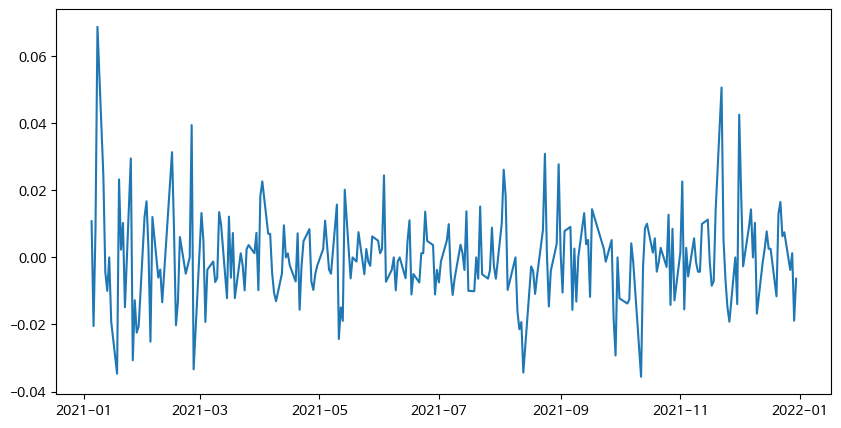

In [39]:
import numpy as np
datapct=data.pct_change()   #주가인 경우 수익율
logreturn=np.log(1+datapct) #로그수익율
logreturn.head()
print(logreturn.describe())
plt.figure(figsize=(10,5))
plt.plot(logreturn['Close'])
plt.show()

In [40]:
logreturn.dropna()  #NAN을 제거

Open      High       Low     Close    Volume    Change
날짜                                                                    
2021-01-05  0.007380 -0.005942  0.017306  0.010785 -0.089790 -0.822899
2021-01-08  0.006020  0.066615  0.003621  0.068752  0.592082  2.123148
2021-01-11  0.077361  0.072837  0.075398  0.024473  0.425443 -1.055247
2021-01-13 -0.005552 -0.002191  0.014698 -0.009983 -0.299888  0.815336
2021-01-14 -0.012325 -0.013245 -0.004499  0.000000 -0.312294      -inf
...              ...       ...       ...       ...       ...       ...
2021-12-17 -0.021894 -0.006390 -0.007782  0.002567  0.088675 -0.002574
2021-12-22  0.012755  0.013951  0.016635  0.016508  0.182996  0.249477
2021-12-23  0.011342  0.007528  0.006325  0.006277 -0.231009 -0.972020
2021-12-24  0.005000  0.009950  0.011285  0.007481 -0.116335  0.176044
2021-12-30 -0.016342 -0.008766 -0.005109 -0.006365 -0.329596 -1.079756

[132 rows x 6 columns]

In [41]:
from statsmodels.tsa.stattools import adfuller
logreturn=logreturn.dropna()
result=adfuller(logreturn['Close']) #p-value < 0.05
print(result)

(-9.289815856154789, 1.1881075485800211e-15, 0, 131, {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}, -695.3238392201392)


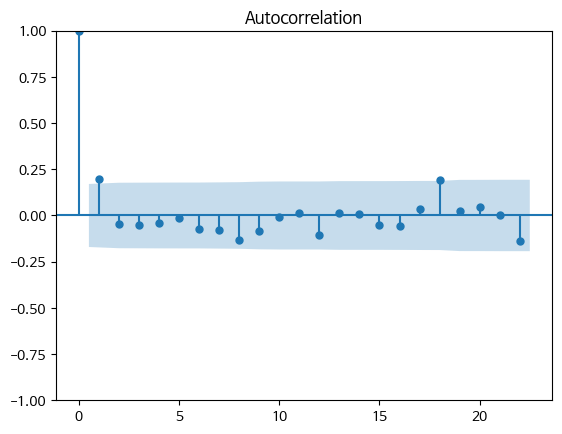

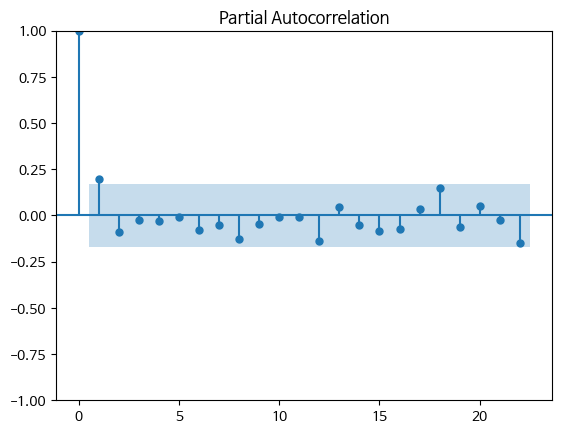

<class 'pandas.core.frame.DataFrame'>


In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(logreturn['Close'])
plot_pacf(logreturn['Close']) #그림에서 절단이 일어나는 위치를 p의 값으로 지정, 24?
plt.show()
print(type(logreturn))

In [51]:
#위에서 정의했던 make_sequence함수를 사용 가능
logr1=logreturn['Close'].values
print(type(logr1))
print(logr1.shape)
logr=logr1.reshape(1,-1)
print(logr.shape)
inte=13 #pacf의 p값
x=[]
y=[]
for i in range(logr.shape[1]):
    if i+inte>logr.shape[1]-1:
        break
    else:
         xx=logr[0,i:i+inte]
         x.append(xx)
         yy=logr[0,i+inte]
         y.append(yy)
print(type(x))
print(type(y))
x=np.array(x)
y=np.array(y)
print(type(x))
print(type(y))
print(x.shape)
print(y.shape)
x_train=x[:100]
x_test=x[100:]
y_train=y[:100]
y_test=y[100:]

<class 'numpy.ndarray'>
(132,)
(1, 132)
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(119, 13)
(119,)


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
from tensorflow.keras import regularizers
model=Sequential()
model.add(Dense(1,input_shape=(inte,))) #p=13, AR(13)모형과 동일, 13개의 x변수를 갖는 셈.
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)


Epoch 1/30
4/4 [==============================] - 1s 4ms/step - loss: 4.1835e-04 - mae: 0.0147
Epoch 2/30
4/4 [==============================] - 0s 6ms/step - loss: 4.0772e-04 - mae: 0.0145
Epoch 3/30
4/4 [==============================] - 0s 4ms/step - loss: 4.0143e-04 - mae: 0.0145
Epoch 4/30
4/4 [==============================] - 0s 9ms/step - loss: 4.0132e-04 - mae: 0.0146
Epoch 5/30
4/4 [==============================] - 0s 5ms/step - loss: 3.9763e-04 - mae: 0.0146
Epoch 6/30
4/4 [==============================] - 0s 4ms/step - loss: 3.9240e-04 - mae: 0.0144
Epoch 7/30
4/4 [==============================] - 0s 6ms/step - loss: 3.8891e-04 - mae: 0.0143
Epoch 8/30
4/4 [==============================] - 0s 8ms/step - loss: 3.8932e-04 - mae: 0.0142
Epoch 9/30
4/4 [==============================] - 0s 5ms/step - loss: 3.8370e-04 - mae: 0.0141
Epoch 10/30
4/4 [==============================] - 0s 6ms/step - loss: 3.7870e-04 - mae: 0.0139
Epoch 11/30
4/4 [==============================] 

In [55]:
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

1/1 [==============================] - 0s 48ms/step - loss: 3.0009e-04 - mae: 0.0140
[0.00032013386953622103, 0.012930759228765965]
[0.0003000891883857548, 0.013961683958768845]


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
model=Sequential()
model.add(Dense(64,activation='relu',input_shape=(inte,)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
4/4 [==============================] - 1s 4ms/step - loss: 1.9550e-04 - mae: 0.0103
Epoch 2/30
4/4 [==============================] - 0s 4ms/step - loss: 2.0193e-04 - mae: 0.0112
Epoch 3/30
4/4 [==============================] - 0s 4ms/step - loss: 1.6477e-04 - mae: 0.0099
Epoch 4/30
4/4 [==============================] - 0s 4ms/step - loss: 1.5871e-04 - mae: 0.0093
Epoch 5/30
4/4 [==============================] - 0s 4ms/step - loss: 1.4594e-04 - mae: 0.0089
Epoch 6/30
4/4 [==============================] - 0s 4ms/step - loss: 1.3773e-04 - mae: 0.0087
Epoch 7/30
4/4 [==============================] - 0s 5ms/step - loss: 1.4228e-04 - mae: 0.0091
Epoch 8/30
4/4 [==============================] - 0s 4ms/step - loss: 1.3590e-04 - mae: 0.0088
Epoch 9/30
4/4 [==============================] - 0s 6ms/step - loss: 1.3073e-04 - mae: 0.0086
Epoch 10/30
4/4 [==============================] - 0s 4ms/step - loss: 1.2865e-04 - mae: 0.0085
Epoch 11/30
4/4 [==============================] 

In [58]:
#RNN을 위해서 shape변경
x_train=x_train.reshape(-1,1,inte)    #210, 1, 13
x_test=x_test.reshape(-1,1,inte)  #24, 1, 13

In [59]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM  #(sample, timestep, features 형태의 데이터)
model=Sequential()
model.add(LSTM(32, input_shape=(1,inte)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
4/4 [==============================] - 4s 6ms/step - loss: 1.6597e-04 - mae: 0.0091
Epoch 2/30
4/4 [==============================] - 0s 5ms/step - loss: 1.8296e-04 - mae: 0.0102
Epoch 3/30
4/4 [==============================] - 0s 5ms/step - loss: 1.6810e-04 - mae: 0.0096
Epoch 4/30
4/4 [==============================] - 0s 5ms/step - loss: 1.5940e-04 - mae: 0.0089
Epoch 5/30
4/4 [==============================] - 0s 5ms/step - loss: 1.5892e-04 - mae: 0.0089
Epoch 6/30
4/4 [==============================] - 0s 7ms/step - loss: 1.5564e-04 - mae: 0.0089
Epoch 7/30
4/4 [==============================] - 0s 6ms/step - loss: 1.5377e-04 - mae: 0.0089
Epoch 8/30
4/4 [==============================] - 0s 5ms/step - loss: 1.5260e-04 - mae: 0.0089
Epoch 9/30
4/4 [==============================] - 0s 5ms/step - loss: 1.5100e-04 - mae: 0.0088
Epoch 10/30
4/4 [==============================] - 0s 5ms/step - loss: 1.4993e-04 - mae: 0.0088
Epoch 11/30
4/4 [==============================] 

In [60]:
model=Sequential()
model.add(GRU(32, input_shape=(1,inte)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
model.fit(x_train,y_train,epochs=30,batch_size=32)
loss_acc=model.evaluate(x_train,y_train)
los_test=model.evaluate(x_test,y_test)
print(loss_acc)
print(los_test)

Epoch 1/30
4/4 [==============================] - 2s 5ms/step - loss: 1.9330e-04 - mae: 0.0108
Epoch 2/30
4/4 [==============================] - 0s 4ms/step - loss: 1.7847e-04 - mae: 0.0098
Epoch 3/30
4/4 [==============================] - 0s 4ms/step - loss: 1.8688e-04 - mae: 0.0105
Epoch 4/30
4/4 [==============================] - 0s 4ms/step - loss: 2.5207e-04 - mae: 0.0122
Epoch 5/30
4/4 [==============================] - 0s 5ms/step - loss: 1.7136e-04 - mae: 0.0099
Epoch 6/30
4/4 [==============================] - 0s 4ms/step - loss: 1.6566e-04 - mae: 0.0097
Epoch 7/30
4/4 [==============================] - 0s 5ms/step - loss: 1.6418e-04 - mae: 0.0101
Epoch 8/30
4/4 [==============================] - 0s 5ms/step - loss: 1.6910e-04 - mae: 0.0100
Epoch 9/30
4/4 [==============================] - 0s 5ms/step - loss: 1.7608e-04 - mae: 0.0097
Epoch 10/30
4/4 [==============================] - 0s 5ms/step - loss: 1.9986e-04 - mae: 0.0110
Epoch 11/30
4/4 [==============================] 

# 8. LSTM 활용

In [61]:
!pip install scalecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.6 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.18.16-py3-none-any.whl size=116725 sha256=c66d417eba47ce548f74260fdb94b7a8b3e5c5a929f29386f79746cc1606a6ca
  Stored in directory: /root/.cache/pip/wheels/c0/5b/59/3ddbe93f2054e783f032c768c8be0839b5efcfe2ab7ac1ced2
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=b600c32f18f078cfa4081092a71dbf00de86fcf65de3d2dec18023b6de31d9b5
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e070070

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

In [63]:
data = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])

## EDA

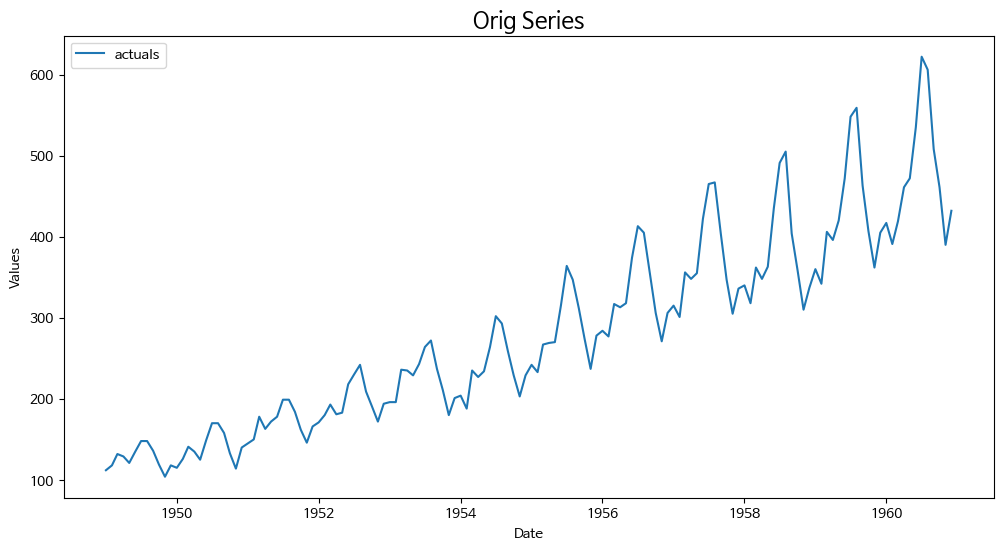

In [64]:
f = Forecaster(
    y=data['#Passengers'],
    current_dates=data['Month'],
    test_length = 12,
    future_dates = 12,
    cis = False,
)
f.plot()
plt.title('Original Time Series',size=16)
plt.show()

In [65]:
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=12
    Xvars=[]
    TestLength=12
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

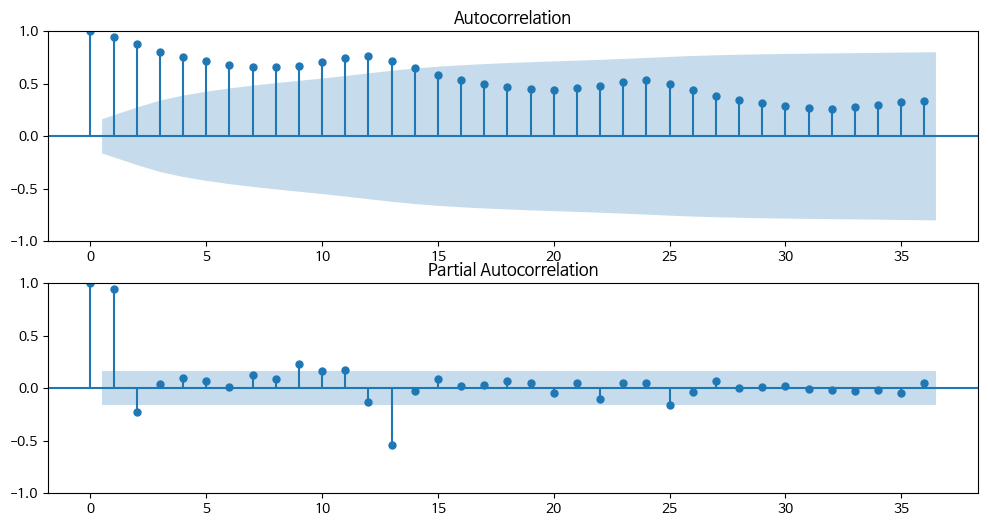

In [66]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(ax=axs[0],lags=36)
f.plot_pacf(ax=axs[1],lags=36)
plt.show()

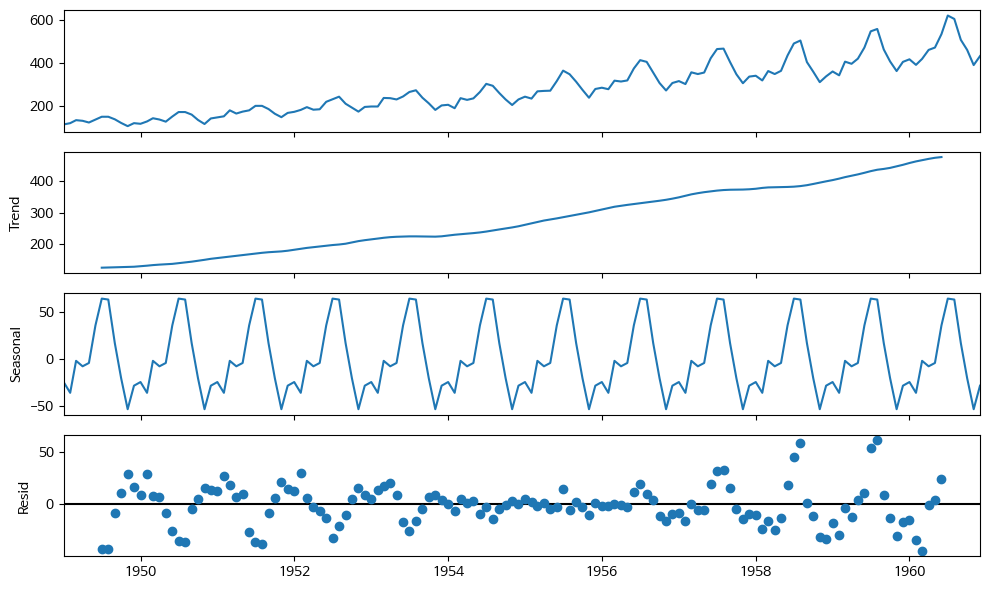

In [67]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

ADF test: non-stationary.

In [68]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: 0.82
the p-value is 0.9919
the series is not stationary
----------------------------------------------------------------------------------------------------


## LSTM Model

### Default parameters 모형

In [69]:
f.set_estimator('lstm')
f.manual_forecast(call_me='lstm_default')

1/1 [==============================] - 1s 638ms/step


5/5 [==============================] - 3s 4ms/step - loss: 0.3385


5/5 [==============================] - 0s 3ms/step


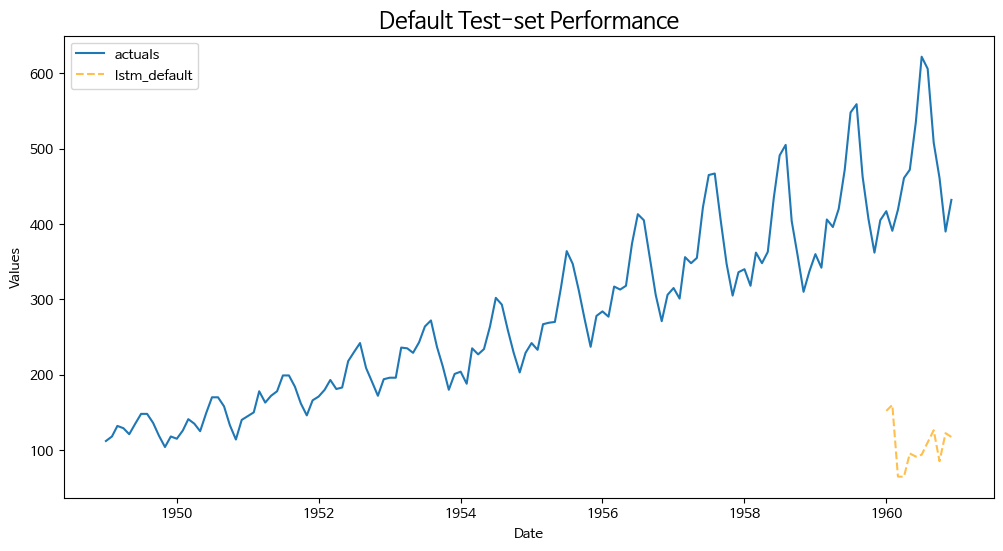

In [70]:
f.plot_test_set()
plt.title('Default Test-set Performance',size=16)
plt.show()

### lags 추가 모형 (2 years).

In [71]:
f.manual_forecast(call_me='lstm_24lags',lags=24)

3/3 [==============================] - 5s 21ms/step - loss: 0.4079


4/4 [==============================] - 0s 6ms/step


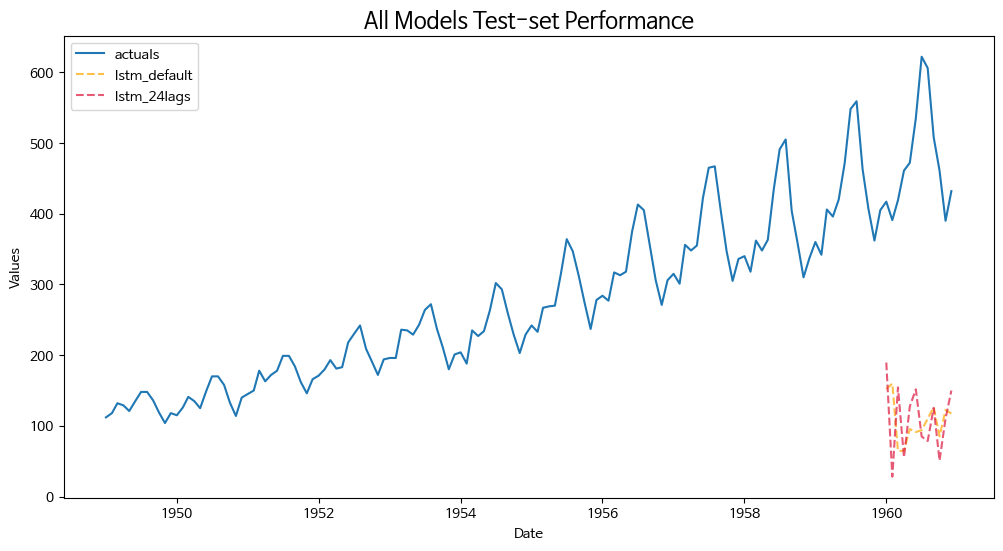

In [72]:
f.plot_test_set()
plt.title('All Models Test-set Performance',size=16)
plt.show()

### epochs 추가 모형.

In [73]:
f.manual_forecast(call_me='lstm_24lags_5epochs',lags=24,epochs=5,validation_split=.2,shuffle=True)

Epoch 1/5
3/3 [==============================] - 3s 294ms/step - loss: 0.3733 - val_loss: 0.6811
Epoch 2/5
3/3 [==============================] - 0s 27ms/step - loss: 0.3668 - val_loss: 0.6726
Epoch 3/5
3/3 [==============================] - 0s 40ms/step - loss: 0.3606 - val_loss: 0.6645
Epoch 4/5
3/3 [==============================] - 0s 30ms/step - loss: 0.3546 - val_loss: 0.6568
Epoch 5/5
1/1 [==============================] - 1s 616ms/step
Epoch 1/5
3/3 [==============================] - 4s 320ms/step - loss: 0.3375 - val_loss: 0.6419
Epoch 2/5
3/3 [==============================] - 0s 37ms/step - loss: 0.3315 - val_loss: 0.6334
Epoch 3/5
3/3 [==============================] - 0s 28ms/step - loss: 0.3252 - val_loss: 0.6244
Epoch 4/5
3/3 [==============================] - 0s 33ms/step - loss: 0.3185 - val_loss: 0.6148
Epoch 5/5
4/4 [==============================] - 0s 4ms/step


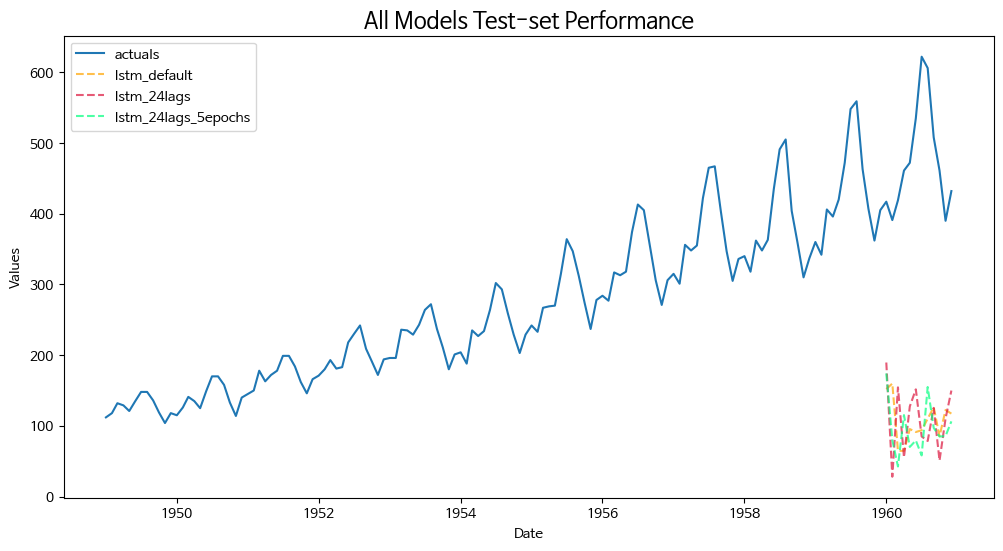

In [74]:
f.plot_test_set()
plt.title('All Models Test-set Performance',size=16)
plt.show()

### layers and early stoping추가

In [75]:
from tensorflow.keras.callbacks import EarlyStopping
f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=5
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0,0)
)

Epoch 1/25
3/3 [==============================] - 8s 700ms/step - loss: 0.3488 - val_loss: 0.6192
Epoch 2/25
3/3 [==============================] - 0s 55ms/step - loss: 0.3361 - val_loss: 0.5990
Epoch 3/25
3/3 [==============================] - 0s 54ms/step - loss: 0.3207 - val_loss: 0.5726
Epoch 4/25
3/3 [==============================] - 0s 58ms/step - loss: 0.3005 - val_loss: 0.5355
Epoch 5/25
3/3 [==============================] - 0s 54ms/step - loss: 0.2724 - val_loss: 0.4809
Epoch 6/25
3/3 [==============================] - 0s 66ms/step - loss: 0.2327 - val_loss: 0.4018
Epoch 7/25
3/3 [==============================] - 0s 60ms/step - loss: 0.1918 - val_loss: 0.3270
Epoch 8/25
3/3 [==============================] - 0s 57ms/step - loss: 0.1656 - val_loss: 0.2700
Epoch 9/25
3/3 [==============================] - 0s 55ms/step - loss: 0.1473 - val_loss: 0.2245
Epoch 10/25
3/3 [==============================] - 0s 59ms/step - loss: 0.1285 - val_loss: 0.2131
Epoch 11/25
3/3 [===========

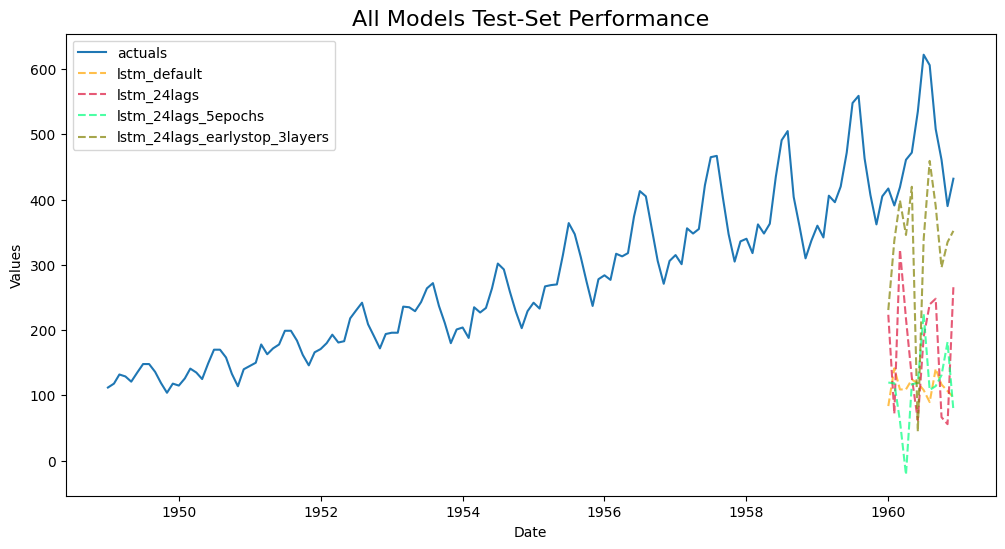

In [ ]:
f.plot_test_set()
plt.title('All Models Test-Set Performance',size=16)
plt.show()

### lags 추가 (3 years).

Epoch 1/15
3/3 [==============================] - 12s 937ms/step - loss: 0.3832 - val_loss: 0.5222
Epoch 2/15
3/3 [==============================] - 0s 116ms/step - loss: 0.2838 - val_loss: 0.2816
Epoch 3/15
3/3 [==============================] - 0s 193ms/step - loss: 0.1797 - val_loss: 0.1800
Epoch 4/15
3/3 [==============================] - 1s 202ms/step - loss: 0.1106 - val_loss: 0.1915
Epoch 5/15
3/3 [==============================] - 1s 204ms/step - loss: 0.1099 - val_loss: 0.1335
Epoch 6/15
3/3 [==============================] - 1s 190ms/step - loss: 0.1053 - val_loss: 0.1233
Epoch 7/15
3/3 [==============================] - 1s 195ms/step - loss: 0.0852 - val_loss: 0.1238
Epoch 8/15
3/3 [==============================] - 1s 216ms/step - loss: 0.0807 - val_loss: 0.1188
Epoch 9/15
3/3 [==============================] - 0s 124ms/step - loss: 0.0776 - val_loss: 0.1240
Epoch 10/15
3/3 [==============================] - 0s 120ms/step - loss: 0.0762 - val_loss: 0.1318
Epoch 11/15
3/3 [=

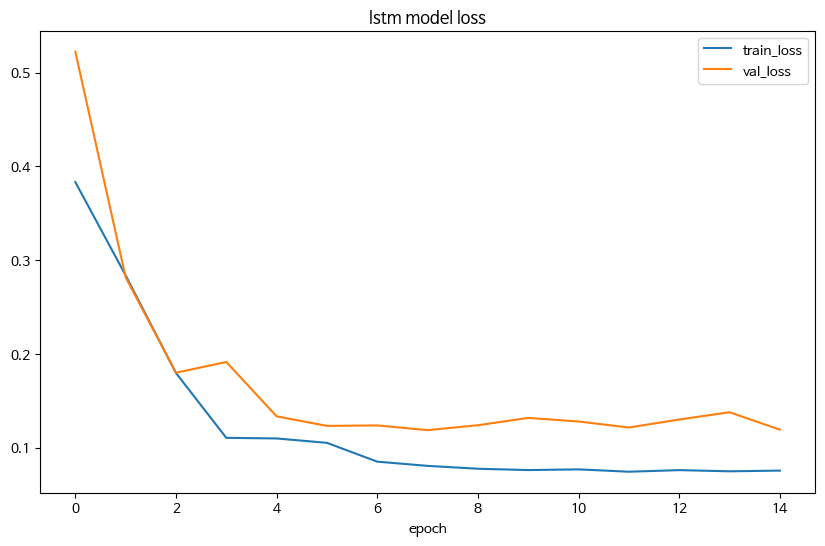

Epoch 1/15
3/3 [==============================] - 11s 961ms/step - loss: 0.3662 - val_loss: 0.5848
Epoch 2/15
3/3 [==============================] - 0s 141ms/step - loss: 0.3033 - val_loss: 0.3607
Epoch 3/15
3/3 [==============================] - 0s 119ms/step - loss: 0.1578 - val_loss: 0.1588
Epoch 4/15
3/3 [==============================] - 0s 141ms/step - loss: 0.1207 - val_loss: 0.2153
Epoch 5/15
3/3 [==============================] - 0s 115ms/step - loss: 0.0992 - val_loss: 0.2126
Epoch 6/15
3/3 [==============================] - 0s 109ms/step - loss: 0.0935 - val_loss: 0.1491
Epoch 7/15
3/3 [==============================] - 0s 113ms/step - loss: 0.0847 - val_loss: 0.1473
Epoch 8/15
3/3 [==============================] - 0s 126ms/step - loss: 0.0787 - val_loss: 0.1634
Epoch 9/15
3/3 [==============================] - 0s 112ms/step - loss: 0.0780 - val_loss: 0.1230
Epoch 10/15
3/3 [==============================] - 0s 116ms/step - loss: 0.0717 - val_loss: 0.1204
Epoch 11/15
3/3 [=

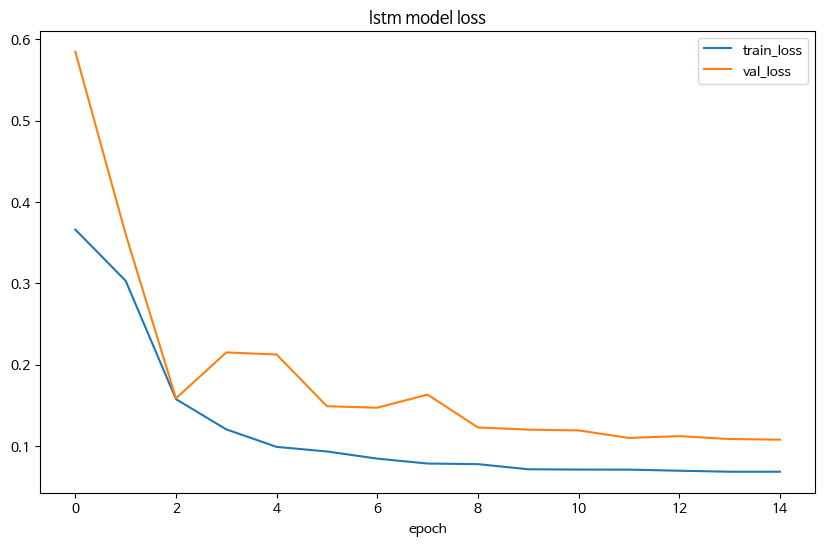

In [76]:
f.manual_forecast(
    call_me='lstm_24lags_4layers_15epochs',
    lags=36,
    batch_size=32,
    epochs=15,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(72,)*4,
    dropout=(0,)*4,
    plot_loss=True
)

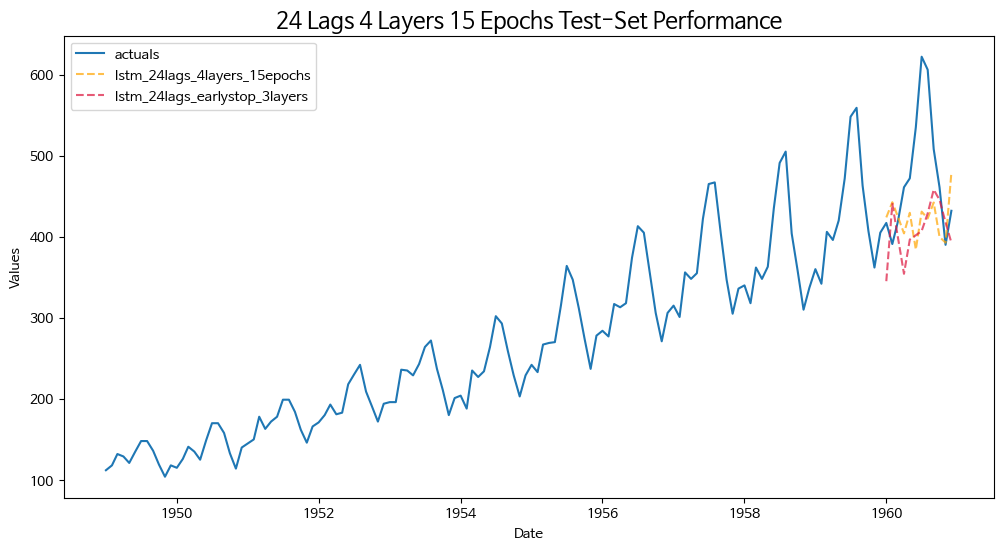

In [78]:
f.plot_test_set(order_by='TestSetMAPE',models='top_2')
plt.title('24 Lags 4 Layers 15 Epochs Test-Set Performance',size=16)
plt.show()



### more layers (15), epochs (300) 추가

Epoch 1/300
5/5 [==============================] - 47s 2s/step - loss: 0.3597 - val_loss: 0.2344
Epoch 2/300
5/5 [==============================] - 2s 436ms/step - loss: 0.1599 - val_loss: 0.3155
Epoch 3/300
5/5 [==============================] - 2s 431ms/step - loss: 0.1412 - val_loss: 0.2514
Epoch 4/300
5/5 [==============================] - 2s 440ms/step - loss: 0.1298 - val_loss: 0.2818
Epoch 5/300
5/5 [==============================] - 4s 752ms/step - loss: 0.1305 - val_loss: 0.2444
Epoch 6/300
5/5 [==============================] - 2s 426ms/step - loss: 0.1226 - val_loss: 0.2630
Epoch 7/300
5/5 [==============================] - 2s 427ms/step - loss: 0.1100 - val_loss: 0.1425
Epoch 8/300
5/5 [==============================] - 2s 439ms/step - loss: 0.0835 - val_loss: 0.1288
Epoch 9/300
5/5 [==============================] - 2s 455ms/step - loss: 0.0859 - val_loss: 0.1234
Epoch 10/300
5/5 [==============================] - 3s 594ms/step - loss: 0.0785 - val_loss: 0.1282
Epoch 11/30

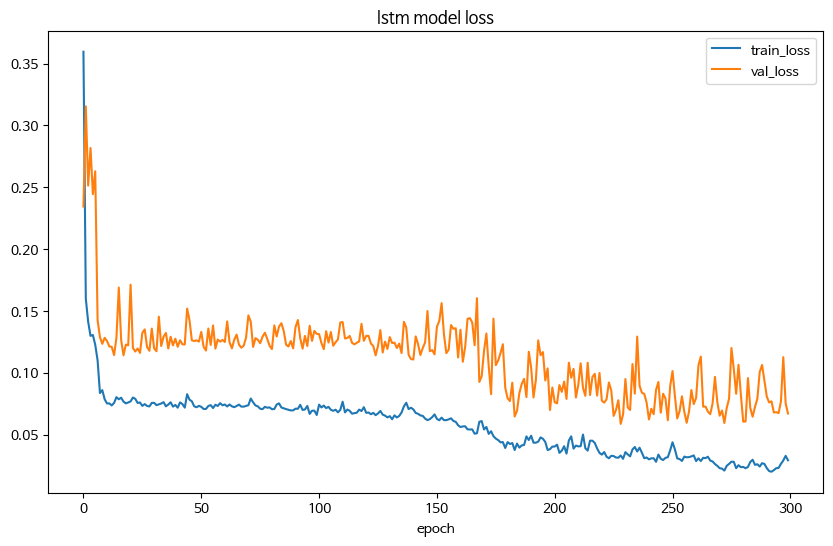

Epoch 1/300
5/5 [==============================] - 42s 2s/step - loss: 0.3247 - val_loss: 0.3099
Epoch 2/300
5/5 [==============================] - 4s 718ms/step - loss: 0.1741 - val_loss: 0.4088
Epoch 3/300
5/5 [==============================] - 2s 477ms/step - loss: 0.1447 - val_loss: 0.2293
Epoch 4/300
5/5 [==============================] - 2s 491ms/step - loss: 0.1378 - val_loss: 0.3555
Epoch 5/300
5/5 [==============================] - 2s 492ms/step - loss: 0.1320 - val_loss: 0.2383
Epoch 6/300
5/5 [==============================] - 2s 458ms/step - loss: 0.1226 - val_loss: 0.3147
Epoch 7/300
5/5 [==============================] - 4s 778ms/step - loss: 0.1163 - val_loss: 0.2106
Epoch 8/300
5/5 [==============================] - 2s 442ms/step - loss: 0.0991 - val_loss: 0.1702
Epoch 9/300
5/5 [==============================] - 2s 493ms/step - loss: 0.0853 - val_loss: 0.2027
Epoch 10/300
5/5 [==============================] - 2s 458ms/step - loss: 0.0803 - val_loss: 0.1293
Epoch 11/30

KeyboardInterrupt: ignored

In [79]:
f.manual_forecast(
    call_me='lstm_best',
    lags=36,
    batch_size=16,
    epochs=300,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(100,)*15,
    dropout=(0,)*15,
    plot_loss=True,
)

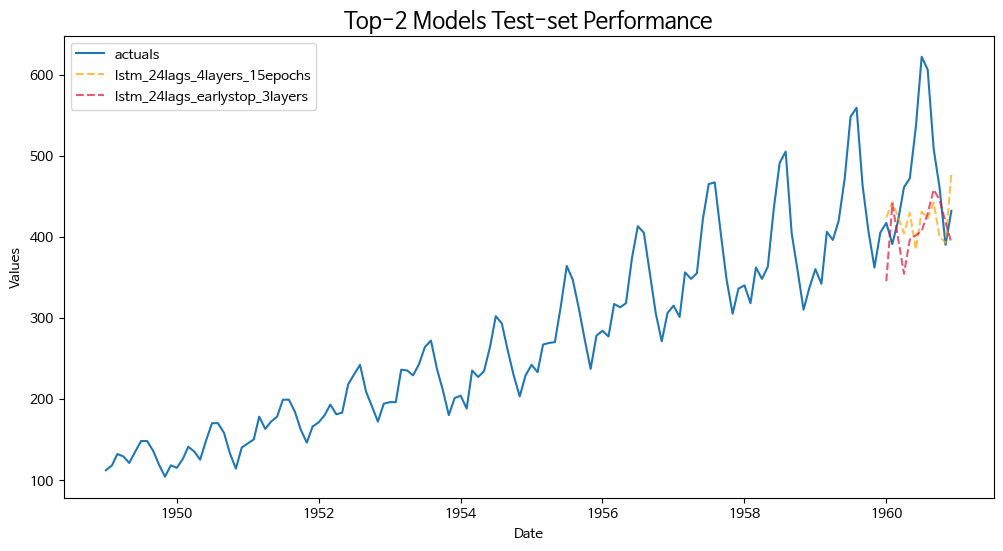

In [80]:
f.plot_test_set(order_by='TestSetMAPE',models='top_2')
plt.title('Top-2 Models Test-set Performance',size=16)
plt.show()

## 다중선형회귀와의 비교
- lags (24): X변수로 추가됨
- 계절 요인 추가 (month, quarter - using dummy vars)
- 연도 및 트렌드 추가
- 차분

In [81]:
from scalecast.SeriesTransformer import SeriesTransformer

transformer = SeriesTransformer(f,deepcopy=False)
f = transformer.DiffTransform()

f.add_ar_terms(24)
f.add_seasonal_regressors('month','quarter',dummy=True)
f.add_seasonal_regressors('year')
f.add_time_trend()

## MLR Modeling

In [82]:
f.set_estimator('mlr')
f.manual_forecast()

In [83]:
f = transformer.DiffRevert(
    exclude_models = [m for m in f.history if m != 'mlr']
)

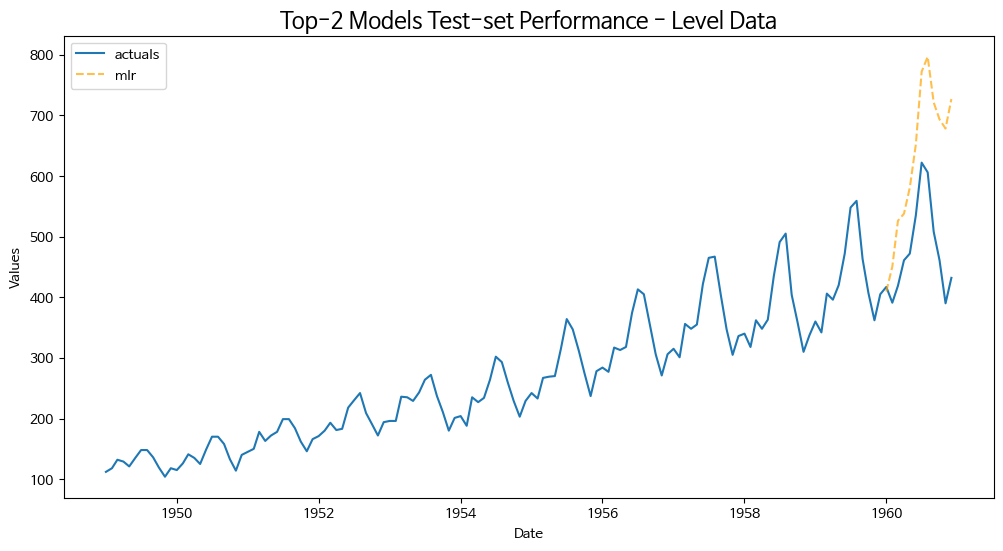

In [84]:
f.plot_test_set(order_by='TestSetMAPE',models=['lstm_best','mlr'])
plt.title('Top-2 Models Test-set Performance - Level Data',size=16)
plt.show()

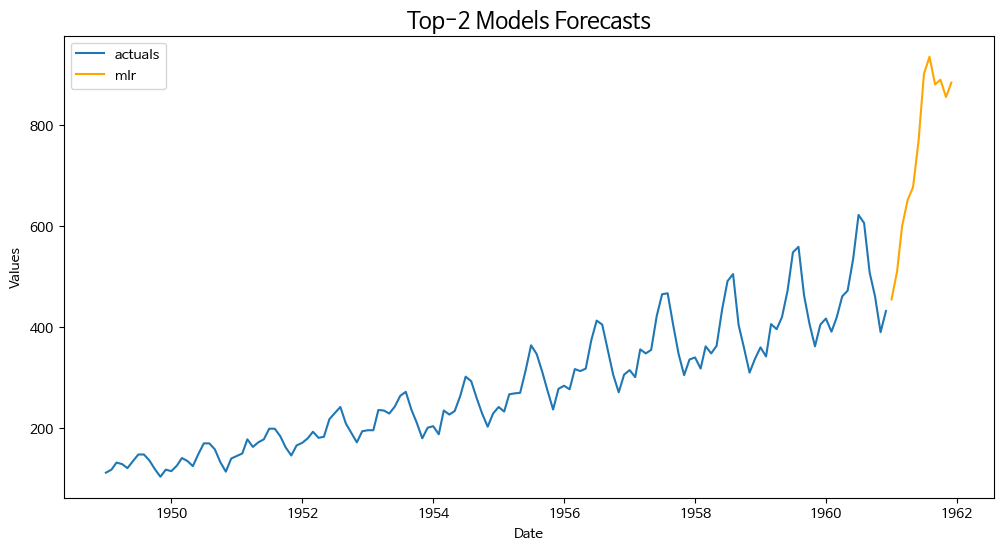

In [85]:
f.plot(order_by='TestSetMAPE',models=['lstm_best','mlr'])
plt.title('Top-2 Models Forecasts',size=16)
plt.show()

## Benchmarking

In [86]:
f.export('model_summaries',determine_best_by='TestSetMAPE')[
    ['ModelNickname','TestSetMAPE','TestSetRMSE','TestSetR2','best_model']
]

ModelNickname  TestSetMAPE  TestSetRMSE  TestSetR2  \
0   lstm_24lags_4layers_15epochs     0.137074    96.168233  -0.669533   
1  lstm_24lags_earlystop_3layers     0.159932   102.263226  -0.887864   
2                            mlr     0.328659   176.765019  -4.640586   
3                    lstm_24lags     0.764770   378.846120 -24.909397   
4                   lstm_default     0.767288   379.392759 -24.984220   
5            lstm_24lags_5epochs     0.794923   389.050415 -26.323943   

   best_model  
0        True  
1       False  
2       False  
3       False  
4       False  
5       False

## Export Results

### Export forecasts

In [ ]:
results = f.export(['lvl_fcsts','lvl_test_set_predictions'],models=['mlr','lstm_best'])
results['lvl_fcsts']

### Export test-set preds

In [ ]:
results['lvl_test_set_predictions']

### Export Feature Info
- For MLR only

In [88]:
f.save_feature_importance()
f.export_feature_importance('mlr')

weight       std
feature                      
AR34       0.681610  0.034564
AR28       0.439113  0.059944
AR31       0.385647  0.079804
year       0.305806  0.010041
t          0.256844  0.021482
AR36       0.201283  0.007572
AR11       0.138667  0.033615
AR22       0.115765  0.012296
AR10       0.108895  0.036866
AR32       0.087471  0.010984
AR1        0.066422  0.025490
AR23       0.034810  0.003997
AR19       0.031495  0.020638
AR21       0.026080  0.036651
month_8    0.012253  0.003770
AR7        0.011397  0.022641
month_10   0.008234  0.003049
quarter_3  0.004980  0.001931
month_2    0.004859  0.006737
AR20       0.003892  0.024839
quarter_1  0.003560  0.001131
AR18       0.003296  0.019936
month_12   0.002290  0.000854
month_5    0.001511  0.004094
month_1    0.000825  0.000718
month_4    0.000291  0.001952
AR13      -0.000339  0.003967
AR9       -0.000658  0.000520
quarter_2 -0.001456  0.001880
quarter   -0.001877  0.000347
month     -0.002136  0.000613
quarter_4 -0.002266  0.002044
month_7   -0.003719  0.006066
AR24      -0.003932  0.000963
AR5       -0.004829  0.009597
month_11  -0.005369  0.002274
AR6       -0.005447  0.004209
AR8       -0.008777  0.018883
AR17      -0.016558  0.018139
month_6   -0.017013  0.013556
month_3   -0.017777  0.004694
AR2       -0.025448  0.035559
AR14      -0.025881  0.013509
AR15      -0.037168  0.025994
AR16      -0.038761  0.027471
month_9   -0.041718  0.004450
AR12      -0.044864  0.007175
AR4       -0.051357  0.013365
AR3       -0.070616  0.020805
AR33      -0.159913  0.039209
AR27      -0.160989  0.028918
AR35      -0.198309  0.024918
AR30      -0.216292  0.041464
AR29      -0.228722  0.060825
AR25      -0.252435  0.023745
AR26      -0.269403  0.026691